In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install featuretools

     |████████████████████████████████| 296kB 2.6MB/s 
     |████████████████████████████████| 655kB 4.6MB/s 
     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 102kB 5.4MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=7b5361a12560ce8e570729293f8dee95072eeba5b59ffbe05baa21c2d3079d7a
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=719ce636c3f6b0b94adda945ef8c3a711e3962ef3634772d0e5a6e4516c6ee67
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2.29.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfu

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
#from sklearn.datasets import

In [ ]:
app_train = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
features = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/application_train.csv")

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, app_test, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', app_test.shape)

train_features.head()
#app_test=test_features.head()
app_test.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
194380,1,427500.0,1252278.0,36747.0,1093500.0,0.020246,-17099,-1646,-4688.0,-632,NaN,1,1,1,1,1,0,3.0,3,3,12,0,0,0,0,0,0,0.590565,0.529565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-744.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
181013,0,112500.0,990000.0,39262.5,990000.0,0.019689,-13827,-2557,-7939.0,-3228,10.0,1,1,0,1,0,0,1.0,2,2,10,0,0,0,0,0,0,0.474450,0.580937,0.483050,0.1175,0.0909,0.9791,0.7144,0.0495,0.0,0.2759,0.1667,0.2083,0.0947,...,0.2759,0.1667,0.2083,0.0963,0.0975,0.1045,0.0000,0.000,0.1078,3.0,1.0,3.0,1.0,-2478.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
106013,0,450000.0,270000.0,13500.0,270000.0,0.005002,-9770,-798,-4551.0,-2436,NaN,1,1,0,1,0,0,2.0,3,3,18,1,1,0,0,0,0,0.350843,0.640554,0.215182,NaN,NaN,0.9737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0061,NaN,NaN,0.0047,1.0,0.0,1.0,0.0,-930.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,3.0
306109,0,135000.0,454500.0,16825.5,454500.0,0.028663,-18471,-1345,-8539.0,-2031,NaN,1,1,0,1,0,0,2.0,2,2,11,0,0,0,0,0,0,NaN,0.555097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
144268,0,157500.0,781920.0,24552.0,675000.0,0.020246,-13725,-835,-3990.0,-1127,NaN,1,1,1,1,0,0,2.0,3,3,10,0,0,0,0,0,0,0.438669,0.104214,0.265049,0.2464,0.1047,0.9767,0.6804,0.1031,0.0,0.5517,0.1667,0.2083,0.1794,...,0.5517,0.1667,0.2083,0.1825,0.2035,0.1606,0.0039,0.001,0.1807,2.0,0.0,2.0,0.0,-614.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


app

In [ ]:
app_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
194380,1,427500.0,1252278.0,36747.0,1093500.0,0.020246,-17099,-1646,-4688.0,-632,NaN,1,1,1,1,1,0,3.0,3,3,12,0,0,0,0,0,0,0.590565,0.529565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-744.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
181013,0,112500.0,990000.0,39262.5,990000.0,0.019689,-13827,-2557,-7939.0,-3228,10.0,1,1,0,1,0,0,1.0,2,2,10,0,0,0,0,0,0,0.474450,0.580937,0.483050,0.1175,0.0909,0.9791,0.7144,0.0495,0.0,0.2759,0.1667,0.2083,0.0947,...,0.2759,0.1667,0.2083,0.0963,0.0975,0.1045,0.0000,0.000,0.1078,3.0,1.0,3.0,1.0,-2478.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
106013,0,450000.0,270000.0,13500.0,270000.0,0.005002,-9770,-798,-4551.0,-2436,NaN,1,1,0,1,0,0,2.0,3,3,18,1,1,0,0,0,0,0.350843,0.640554,0.215182,NaN,NaN,0.9737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0061,NaN,NaN,0.0047,1.0,0.0,1.0,0.0,-930.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,3.0
306109,0,135000.0,454500.0,16825.5,454500.0,0.028663,-18471,-1345,-8539.0,-2031,NaN,1,1,0,1,0,0,2.0,2,2,11,0,0,0,0,0,0,NaN,0.555097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
144268,0,157500.0,781920.0,24552.0,675000.0,0.020246,-13725,-835,-3990.0,-1127,NaN,1,1,1,1,0,0,2.0,3,3,10,0,0,0,0,0,0,0.438669,0.104214,0.265049,0.2464,0.1047,0.9767,0.6804,0.1031,0.0,0.5517,0.1667,0.2083,0.1794,...,0.5517,0.1667,0.2083,0.1825,0.2035,0.1606,0.0039,0.001,0.1807,2.0,0.0,2.0,0.0,-614.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
app_train = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/application_train.csv").sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
Cash = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/POS_CASH_balance.csv").sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/bureau_balance.csv").sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/previous_application.csv").sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
installments = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/installments_payments.csv").sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/credit_card_balance.csv").sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv("/content/drive/My Drive/PRCP-1006-HomeLoanDef/bureau.csv").sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]


In [ ]:
app_types = {}

# Iterate through the columns and record the Boolean columns
for col in app_train:
    # If column is a number with only two values, encode it as a Boolean
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  33


In [ ]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

app_test_types = app_types.copy()
del app_test_types['TARGET']

In [ ]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}


In [ ]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
#app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
Cash = replace_day_outliers(Cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [ ]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [ ]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


In [ ]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']


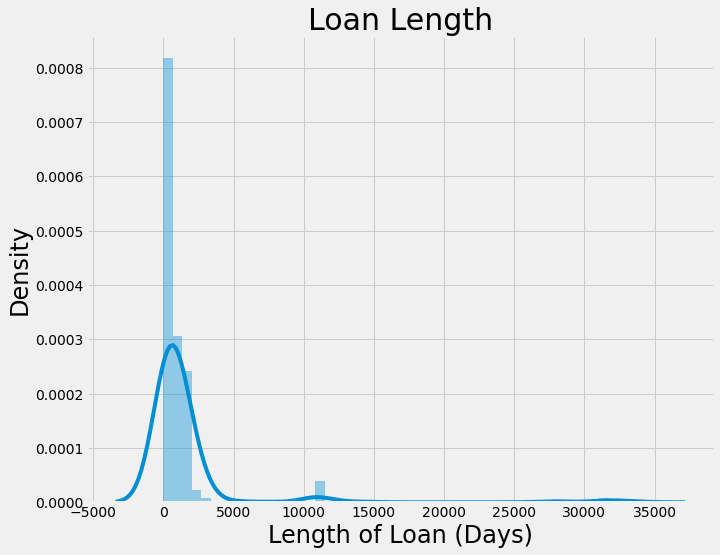

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

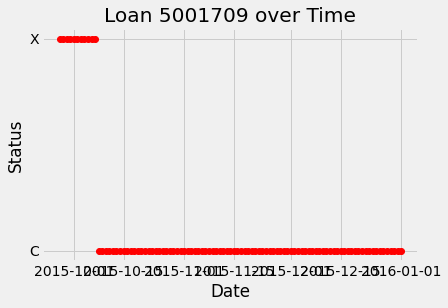

In [ ]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'D')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

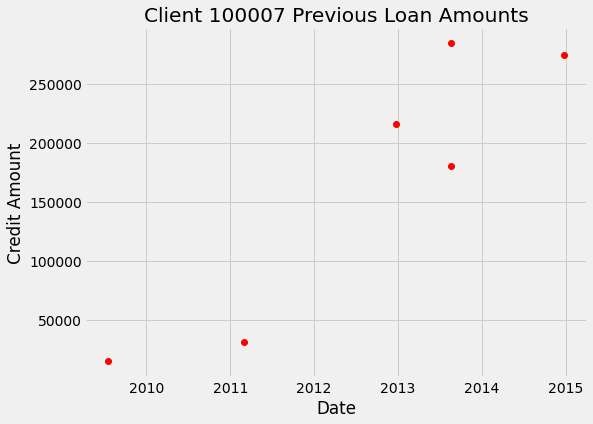

In [ ]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

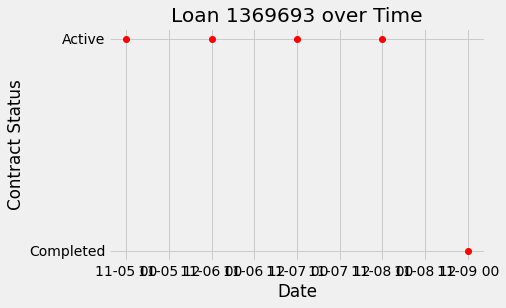

In [ ]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'D')
Cash['MONTHS_BALANCE'] = pd.to_timedelta(Cash['MONTHS_BALANCE'], 'D')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
Cash['cash_balance_date'] = start_date + Cash['MONTHS_BALANCE']
Cash = Cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = Cash[Cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');


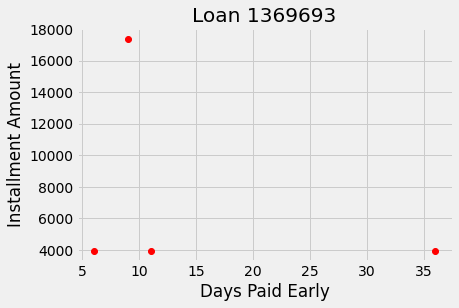

In [ ]:
# Convert to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');


#Applying Features Tools

In [ ]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

In [ ]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'app_test', dataframe = app_test, 
                             index = 'SK_ID_CURR', variable_types = app_test_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              variable_types = previous_types)

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'Cash', dataframe = Cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')


In [ ]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app_train']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Test Relationship between app and bureau
r_test_app_bureau = ft.Relationship(es['app_test']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app_train']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Test Relationship between current app and previous apps
r_test_app_previous = ft.Relationship(es['app_test']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['Cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous, 
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 6000, Columns: 105]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    Cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    Cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [ ]:
time_features, time_feature_names = ft.dfs(entityset = es, target_entity = 'app_train', 
                                           trans_primitives = ['cum_sum', 'time_since_previous'], max_depth = 2,
                                           agg_primitives = ['trend'] ,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train))
                                           

Built 452 features
Elapsed: 00:43 | Progress: 100%|██████████


In [ ]:
time_features.iloc[:, -10:].head()

,"CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))","CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))","CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))","CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))","CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))","CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))","CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))"
SK_ID_CURR,,,,,,,,,,
100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,367.444774,418.305454,NaN,367.444774,-0.001774,-0.000448,NaN,NaN,NaN,0.285154
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,630.070715,776.928357,NaN,1391.162781,0.045124,0.002063,NaN,NaN,NaN,-1.333402
100007,762.957307,928.679814,NaN,1524.049373,0.055780,0.000891,NaN,NaN,NaN,-1.706613


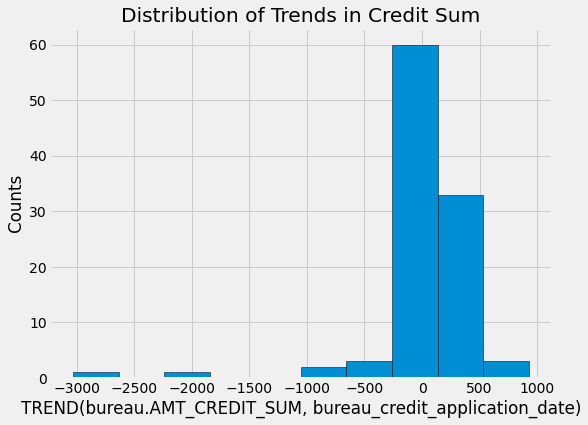

In [ ]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

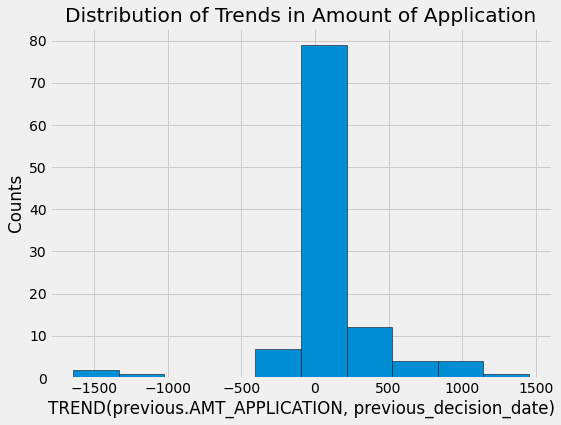

In [ ]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [ ]:
time_feature_names[-10:]

[<Feature: CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))>]

In [ ]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset=es, target_entity='app_train', max_depth = 1, 
                                                         where_primitives = ['mean', 'mode'], 
                                                         trans_primitives=[], features_only = False, verbose = True,
                                                         chunk_size = len(app_train))
                                                         

Built 355 features
Elapsed: 00:03 | Progress: 100%|██████████


In [ ]:
interesting_features.iloc[:, -6:, ].head()

,MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Canceled),MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Approved),MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Refused),MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Canceled),MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Approved),MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Refused)
SK_ID_CURR,,,,,,
100002,NaN,POS other with interest,NaN,NaN,SATURDAY,NaN
100003,NaN,Cash X-Sell: low,NaN,NaN,FRIDAY,NaN
100004,NaN,POS mobile without interest,NaN,NaN,FRIDAY,NaN
100006,Cash,Card X-Sell,Cash X-Sell: low,THURSDAY,THURSDAY,THURSDAY
100007,NaN,Cash X-Sell: middle,NaN,NaN,SUNDAY,NaN


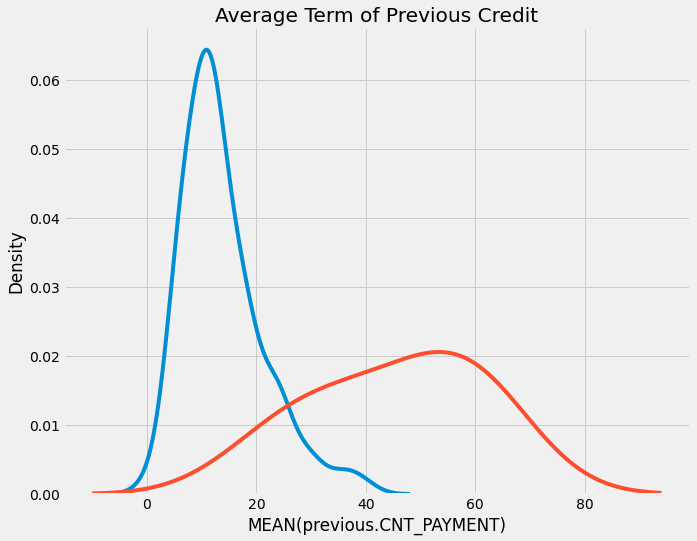

In [ ]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Term of Previous Credit');

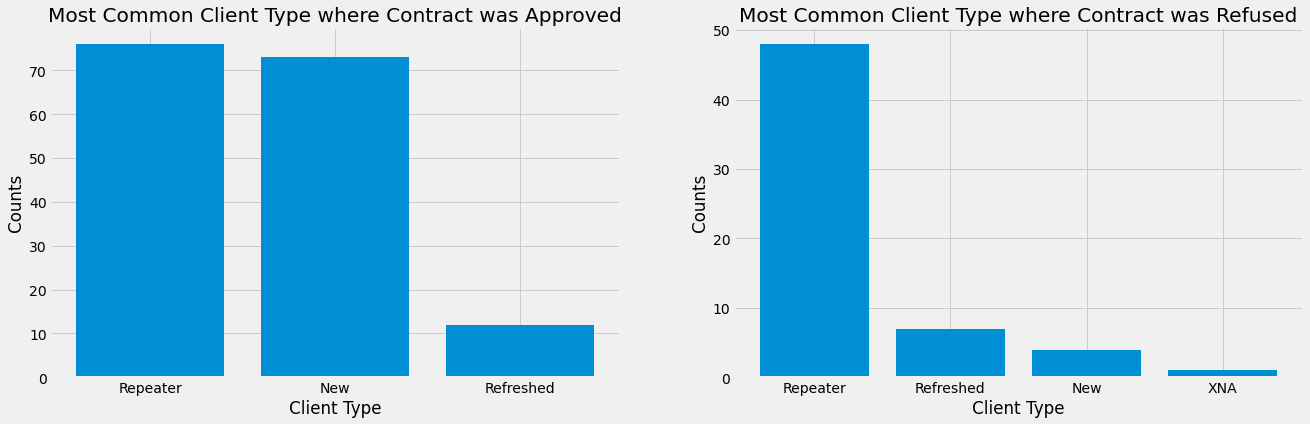

In [ ]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.bar(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts())
plt.xticks(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Approved");

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Refused");


#Seed Features

In [ ]:
# This time when we make the dfs function call, we need to pass in the seed_features argument.

# Late Payment seed feature
late_payment = ft.Feature(es['installments']['installments_due_date']) < ft.Feature(es['installments']['installments_paid_date'])

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train))
                                        

Built 251 features
Elapsed: 00:00 | Progress: 100%|██████████


In [ ]:
seed_features.iloc[:, -2:].head(10)

,PERCENT_TRUE(credit.previous.NFLAG_LAST_APPL_IN_DAY),MEAN(previous.PERCENT_TRUE(installments.late_payment))
SK_ID_CURR,,
100002,0.0,0.000000
100003,0.0,0.000000
100004,0.0,0.000000
100006,1.0,0.000000
100007,0.0,0.239927
100008,0.0,0.018182
100009,0.0,0.000000
100010,0.0,0.000000
100011,1.0,0.207870


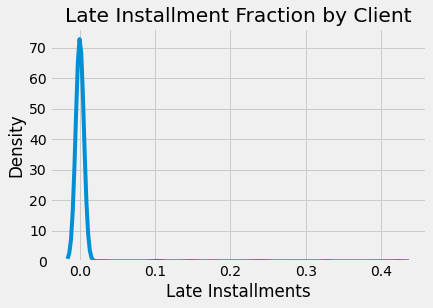

In [ ]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

In [ ]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [ ]:
# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train))
                                          

Built 251 features
Elapsed: 00:00 | Progress: 100%|██████████


#Create Custom Feature Primitives

In [ ]:
from featuretools.variable_types import (
    Boolean, Datetime,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable,
    Id
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta

from collections import Counter


def normalized_mode_count(x):
    """
    Return the fraction of total observations that 
    are the most common observation. For example, 
    in an array of ['A', 'A', 'A', 'B', 'B'], the 
    function will return 0.6."""
    
    if x.mode().shape[0] == 0:
        return np.nan
            
    # Count occurence of each value
    counts = dict(Counter(x.values))
    # Find the mode
    mode = x.mode().iloc[0]
    # Divide the occurences of mode by the total occurrences
    return counts[mode] / np.sum(list(counts.values()))
    

NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
                                         input_types = [Discrete],
                                         return_type = Numeric)

# Function from https://codereview.stackexchange.com/a/15095
def longest_repetition(x):
    """
    Returns the item with most consecutive occurrences in `x`. 
    If there are multiple items with the same number of conseqcutive occurrences,
    it will return the first one. If `x` is empty, returns None. 
    """
    
    x = x.dropna()
    
    if x.shape[0] < 1:
        return None
    
    # Set the longest element
    longest_element = current_element = None
    longest_repeats = current_repeats = 0
    
    # Iterate through the iterable
    for element in x:
        if current_element == element:
            current_repeats += 1
        else:
            current_element = element
            current_repeats = 1
        if current_repeats > longest_repeats:
            longest_repeats = current_repeats
            longest_element = current_element
            
    return longest_element

LongestSeq = make_agg_primitive(function = longest_repetition,
                                     input_types = [Discrete],
                                     return_type = Discrete)    


In [ ]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = [NormalizedModeCount, LongestSeq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train))
                                              

custom_features.iloc[:, -40:].head()

Built 281 features
Elapsed: 00:04 | Progress: 100%|██████████


,NORMALIZED_MODE_COUNT(installments.previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(installments.previous.NAME_TYPE_SUITE),NORMALIZED_MODE_COUNT(installments.previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(installments.previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(installments.previous.SK_ID_CURR),NORMALIZED_MODE_COUNT(installments.previous.WEEKDAY_APPR_PROCESS_START),LONGEST_REPETITION(credit.previous.CHANNEL_TYPE),LONGEST_REPETITION(credit.previous.CODE_REJECT_REASON),LONGEST_REPETITION(credit.previous.FLAG_LAST_APPL_PER_CONTRACT),LONGEST_REPETITION(credit.previous.NAME_CASH_LOAN_PURPOSE),LONGEST_REPETITION(credit.previous.NAME_CLIENT_TYPE),LONGEST_REPETITION(credit.previous.NAME_CONTRACT_STATUS),LONGEST_REPETITION(credit.previous.NAME_CONTRACT_TYPE),LONGEST_REPETITION(credit.previous.NAME_GOODS_CATEGORY),LONGEST_REPETITION(credit.previous.NAME_PAYMENT_TYPE),LONGEST_REPETITION(credit.previous.NAME_PORTFOLIO),LONGEST_REPETITION(credit.previous.NAME_PRODUCT_TYPE),LONGEST_REPETITION(credit.previous.NAME_SELLER_INDUSTRY),LONGEST_REPETITION(credit.previous.NAME_TYPE_SUITE),LONGEST_REPETITION(credit.previous.NAME_YIELD_GROUP),LONGEST_REPETITION(credit.previous.PRODUCT_COMBINATION),LONGEST_REPETITION(credit.previous.SK_ID_CURR),LONGEST_REPETITION(credit.previous.WEEKDAY_APPR_PROCESS_START),NORMALIZED_MODE_COUNT(credit.previous.CHANNEL_TYPE),NORMALIZED_MODE_COUNT(credit.previous.CODE_REJECT_REASON),NORMALIZED_MODE_COUNT(credit.previous.FLAG_LAST_APPL_PER_CONTRACT),NORMALIZED_MODE_COUNT(credit.previous.NAME_CASH_LOAN_PURPOSE),NORMALIZED_MODE_COUNT(credit.previous.NAME_CLIENT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_CONTRACT_STATUS),NORMALIZED_MODE_COUNT(credit.previous.NAME_CONTRACT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_GOODS_CATEGORY),NORMALIZED_MODE_COUNT(credit.previous.NAME_PAYMENT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_PORTFOLIO),NORMALIZED_MODE_COUNT(credit.previous.NAME_PRODUCT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(credit.previous.NAME_TYPE_SUITE),NORMALIZED_MODE_COUNT(credit.previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(credit.previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(credit.previous.SK_ID_CURR),NORMALIZED_MODE_COUNT(credit.previous.WEEKDAY_APPR_PROCESS_START)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1.000000,NaN,1.000000,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.480000,0.720000,0.720000,0.480000,1.0,0.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.625000,0.625000,0.625000,0.625000,1.0,0.625000,Credit and cash offices,XAP,Y,XAP,Repeater,Approved,Revolving loans,XNA,XNA,Cards,x-sell,XNA,Unaccompanied,XNA,Card X-Sell,100006.0,THURSDAY,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100007,0.606061,0.469697,0.621212,0.378788,1.0,0.469697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


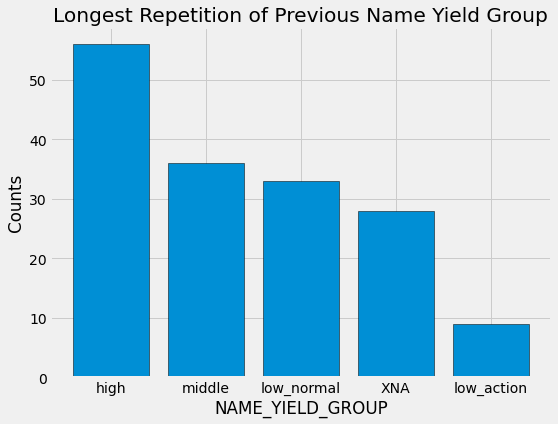

In [ ]:
plt.figure(figsize = (8, 6))
plt.bar(custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts().index, custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts(), edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP'); plt.ylabel('Counts'); plt.title('Longest Repetition of Previous Name Yield Group');

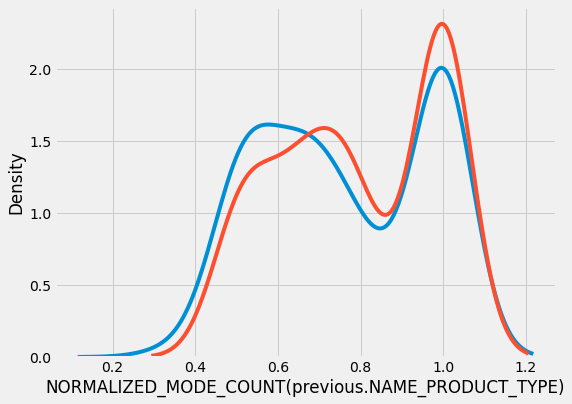

In [ ]:
plt.figure(figsize = (8, 6))
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

In [ ]:
# Building on the Trend Aggregation Primitive
# Copied from https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py

def most_recent(y, x):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
            
    if df.shape[0] < 1:
        return np.nan

    # Sort the values by timestamps reversed
    df = df.sort_values('x', ascending = False).reset_index()

    # Return the most recent occurence
    return df.iloc[0]['y']

MostRecent = make_agg_primitive(function = most_recent,
                                input_types = [Discrete, Datetime],
                                return_type = Discrete)

In [ ]:
# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = ['last', MostRecent],
                                               max_depth = 1,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train)
                                              ignore_entities = ['app_test'])
                                              

SyntaxError: ignored

In [ ]:
custom_features[['MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)', 'MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)']].head(10)

In [ ]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_entities = ['app_test'])
                                       

In [ ]:
import random
random.sample(feature_names, 10)

In [ ]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))